<a href="https://colab.research.google.com/github/yiyixuxu/denoising-diffusion-flax/blob/main/ddpm_flax_oxford102_end_to_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Diffusion Probabilistic Model in Flax

Demonstration notebook for
https://github.com/yiyixuxu/denoising-diffusion-flax

* this notebook is forked from [flax examples](https://github.com/google/flax/tree/main/examples)

The **DDPM-flax Notebook Workflow**:

1. Understand the different different configuration options  
  - This will open config files (`/configs/config_colab.py`) in the right-hand editor! you can edit your config file as you go through this section  
2. train a model from scratch and check out the outputs.
3. Generate beautiful flower samples from a pre-trained model

## Setup

In [1]:
%%capture
! pip install clu
! pip install wandb
! pip install einops

In [90]:
import jax
import jax.numpy as jnp
from ml_collections import config_dict
import tensorflow as tf
import tensorflow_datasets as tfds
from flax import jax_utils
from flax.training import checkpoints
from einops import rearrange, repeat
import numpy as np
import torch
from tqdm import tqdm, trange

In [3]:
import wandb
import math

In [85]:
import matplotlib.pyplot as plt 
from PIL import Image
import functools

### setup the ddpm-flax project and open the config file 

In [4]:
# if you have created a different config file, update it here, otherwise we will use the default config file
# you can also open other files if you want to edit them e.g. train.py
editor_relpaths = ('configs/oxford102_colab.py',)

In [ ]:
root_directory = 'denoising-diffusion-flax'
example_directory = 'denoising-diffusion-flax/denoising_diffusion_flax'
repo, branch =  'https://github.com/yiyixuxu/denoising-diffusion-flax', 'main'

In [5]:
# (If you run this code in Jupyter[lab], then you're already in the
#  example directory and nothing needs to be done.)

#@markdown
#@markdown **If you select no** below, then the files will be stored on the
#@markdown *ephemeral* Colab VM. **After some time of inactivity, this VM will
#@markdown be restarted an any changes are lost**.
#@markdown
#@markdown **If you select yes** below, then you will be asked for your
#@markdown credentials to mount your personal Google Drive. In this case, all
#@markdown changes you make will be *persisted*, and even if you re-run the
#@markdown Colab later on, the files will still be the same (you can of course
#@markdown remove directories inside your Drive's `flax/` root if you want to
#@markdown manually revert these files).

if 'google.colab' in str(get_ipython()):
  import os
 
  mount_gdrive = 'no' #@param ['yes', 'no']
  if mount_gdrive == 'yes':
    example_root_path = f'/content/gdrive/My Drive/{example_directory}'
    DISCLAIMER = 'Note : Editing in your Google Drive, changes will persist.'
    from google.colab import drive
    drive.mount('/content/gdrive/')
    os.chdir('/content/gdrive/My Drive')
    # Download ddpm-flax repo from Github.
    if not os.path.isdir(root_directory):
      !git clone -b $branch $repo
    os.chdir(example_root_path)
  else:
    DISCLAIMER = 'WARNING : Editing in VM - changes lost after reboot!!'
    example_root_path = f'/content/{example_directory}'
    os.chdir('/content/')
    if not os.path.isdir(root_directory):
      !git clone -b $branch $repo

    from IPython import display
    display.display(display.HTML(
        f'<h1 style="color:red;" class="blink">{DISCLAIMER}</h1>'))
    print(example_root_path)
    os.chdir(example_root_path)
  from google.colab import files
  for relpath in editor_relpaths:
    s = open(f'{example_root_path}/{relpath}').read()
    open(f'{example_root_path}/{relpath}', 'w').write(
        f'## {DISCLAIMER}\n' + '#' * (len(DISCLAIMER) + 3) + '\n\n' + s)
    files.view(f'{example_root_path}/{relpath}')

Cloning into 'denoising-diffusion-flax'...
remote: Enumerating objects: 244, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 244 (delta 142), reused 155 (delta 72), pack-reused 0
Receiving objects: 100% (244/244), 2.08 MiB | 13.01 MiB/s, done.
Resolving deltas: 100% (142/142), done.


/content/denoising-diffusion-flax/denoising_diffusion_flax


<IPython.core.display.Javascript object>

In [6]:
# make sure you are in the ddmp-flax repo 
! pwd

/content/denoising-diffusion-flax/denoising_diffusion_flax


### TPU setup

* If you wish to use TPU, please change your runtime type to TPU and check the box below 
  * Note that <font color=red>__TPU colab is NOT working correctly__ </font> at the moment, see issue here https://github.com/googlecolab/colabtools/issues/3009
  * *(I will remove this comment once the issue is resolved)*

* otherwise, please change your runtime type to GPU


In [ ]:
# select tpu if you have it
# (it is not working correctly with colab at the moment)
use_tpu = False #@param {type:"boolean"}
if use_tpu:
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()

## import & helpers

In [25]:
# Local imports from current directory - auto reload.
# Any changes you make to train.py will appear automatically.
%load_ext autoreload
%autoreload 2

import train
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def to_np(x):
  """Converts TF/JAX tensors to numpy."""
  return np.asarray(x, dtype=np.float32)

def to_wandb_img(img):
    img = rearrange(to_np(img), ' d b h w c -> (d b) c h w')
    if img.shape[1] == 1:
      img = repeat(img, 'b c h w -> b (repeat c) h w', repeat =3)
    return torch.tensor(img)

## Configure your training

load your config file

In [13]:
from configs import oxford102_colab as config_lib
my_config = config_lib.get_config()

### data

In [16]:
my_config.data

batch_size: 4
cache: false
channels: 3
dataset: oxford_flowers102
image_size: 128

In [15]:
#my_config.data.batch_size=4
#my_config.data.image_size=256

In [17]:
rng = jax.random.PRNGKey(0)
train_it = train.get_dataset(rng, my_config)
img = next(train_it)['image']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteLEEETH/oxford_flowers102-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteLEEETH/oxford_flowers102-test.tfrecord*...: …

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteLEEETH/oxford_flowers102-validation.tfrecord…

Dataset oxford_flowers102 downloaded and prepared to ~/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [18]:
img.shape

(1, 4, 128, 128, 3)

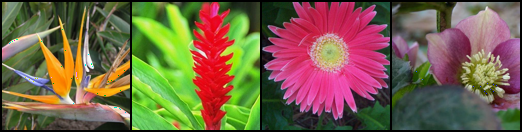

In [19]:
wandb.Image(to_wandb_img(img)).image

### wandb logging

I turned off wandb logging for this notebook, if you have an wandb, feel free to enable w&B logging by edit these options

In [21]:
my_config.wandb

entity: null
job_type: training
log_model: true
log_sample: true
log_train: true
name: null
project: ddpm-flax-flower102

### p2 weighting

__P2 (perception prioritized) weighting__ optimizes the weighting scheme of the training objective function to improve sample quality. It encourages the diffusion model to focus on recovering signals from __highly corrupted data__ (i.e. when noise level is higher), where the model learns global and perceptually rich concepts. 

You can read more about P2 weighting in the [paper](https://arxiv.org/abs/2204.00227) and check out the github [repo](https://github.com/jychoi118/P2-weighting)

You can apply it by change the values of p2 hyperparameters in config file:
* `config.ddpm.p2_loss_weight_gamma` 
* `config.ddpm.p2_loss_weight_k`; 

the paper recomend use `p2_loss_weight_gamma=1` and `p2_loss_weight_k=1`; In my own experience, using P2 weighting will train much faster and greatly improve sample quality



current value of p2 hyperparameters

In [23]:
my_config.ddpm.p2_loss_weight_gamma

1.0

In [24]:
my_config.ddpm.p2_loss_weight_k

1

when you change `p2_loss_weight_gamma` to `0` - every noise level gets same weight, so P2 weighting is not applied

In [35]:
my_config.ddpm.p2_loss_weight_gamma = 0

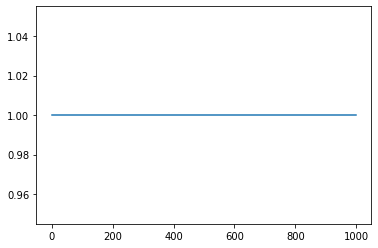

In [36]:
p2_weights = utils.get_ddpm_params(my_config.ddpm)['p2_loss_weight']
plt.plot(range(len(p2_weights)),p2_weights)

when you change `p2_loss_weight_gamma` to `1` - the more corrupted data will get higher weight when calculating the loss 

as you can see in below chart, p2 weight (y-axis) increase as the noise level/ timestep (x-axis) increases

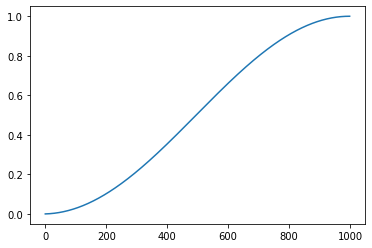

In [32]:
my_config.ddpm.p2_loss_weight_gamma = 1
p2_weights = utils.get_ddpm_params(my_config.ddpm)['p2_loss_weight']
plt.plot(range(len(p2_weights)),p2_weights)

### model EMA

we will keep track of an exponential moving average version of the model and use it to generate samples. You can find the list of hyperparameters with default values for ema calculation

* `inv_gamma` and `power` is used to calculate `ema_decay` rate for each training step
  * `ema_decay = (1 + steps / config.inv_gamma) ** - config.power `
* `min_value` and `beta` determine the minimum and maximum `ema_decay`
* `update_after_step` determines when to start average the model
*  `update_every` determines the how often we average the model 

In [37]:
my_config.ema

beta: 0.995
inv_gamma: 1.0
min_value: 0.0
power: 0.6666666666666666
update_after_step: 100
update_every: 10

change the `my_config.ema.inv_gamme` and `my_config.ema.power` to see how it affect `ema_decay` rate through out the training process 

In [39]:
ema_decay_fn = train.create_ema_decay_schedule(my_config.ema)

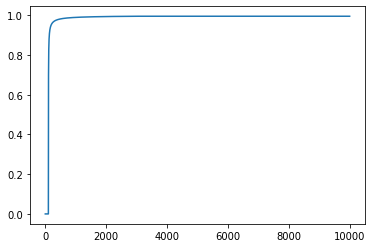

In [43]:
plt.plot(range(10000), [ema_decay_fn(t).item() for t in range(10000)])

we then use `ema_decay` to calculate the exponential moving average of model parameters at every `10` training steps ( when `ema.update_every=10`)

```parameter_ema = parameters * (1- ema_decay) + parameter_ema * ema_decay```

see `apply_ema_decay` function for more details

In [44]:
train.apply_ema_decay??

### beta schedule

we currently provide 2 beta schedules: `cosine` or `linear`, if you pass any value other than these 2, you will get an exception

it determine the beta value at each timestep, which then determine all ddpm parameters 

linear schedule

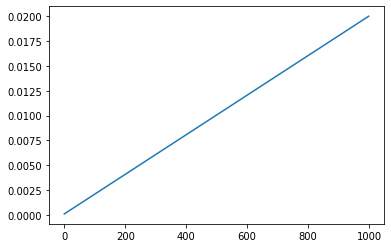

In [49]:
plt.plot(range(my_config.ddpm.timesteps), utils.linear_beta_schedule(my_config.ddpm.timesteps))

cosine schedule is proposed in this paper https://arxiv.org/abs/2102.09672

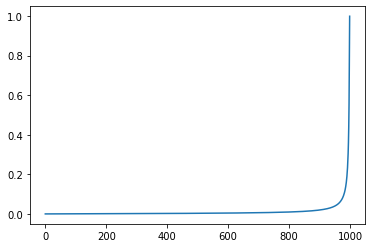

In [50]:
plt.plot(range(my_config.ddpm.timesteps), utils.cosine_beta_schedule(my_config.ddpm.timesteps))

### self_conditioning

Self-Conditioning is a useful technique for improving diffusion models. In a typical diffusion sampling process, the model iteratively predict `x0` in order to gradually denoise the image, and the `x0` estimated from previous step is discard in the new step; with self-conditioning, the model will also take previously generated samples as input.

You read more about the technique in the paper [Analog Bits: Generating Discrete Data using Diffusion Models with Self-Conditioning](https://arxiv.org/abs/2208.04202)

If you wish to apply self-conditioning, set `config.ddpm.self_condition=True`;

In [52]:
my_config.ddpm.self_condition

False

see __the implementation for self-condition__ in `model_predict` function

basically, if we choose to apply self-condition, at 50% of the training steps, we would run below additional process to get model prediction:
1. create a zero tensor with same shape as `x` and concatenate it together with `x` to create new model input 
2. put it through model to get predicted `x0` (if our model predict noise, and by default we do, we need to apply an additional step to estimate `x0` from predicted noise)
3. concatenate the predicted `x0` with `x` to create the input and put it through model again 


```python
# called by p_loss and ddpm_sample_step - both use pmap
def model_predict(state, x, x0, t, ddpm_params, self_condition, is_pred_x0, use_ema=True):
    if use_ema:
        variables = {'params': state.params_ema}
    else:
        variables = {'params': state.params}
    
    if self_condition:
        pred = state.apply_fn(variables, jnp.concatenate([x, x0],axis=-1), t)
    else:
        pred = state.apply_fn(variables, x, t)

    if is_pred_x0: # if the objective is is_pred_x0, pred == x0_pred
        x0_pred = pred
        noise_pred =  x0_to_noise(pred, x, t, ddpm_params)
    else:
        noise_pred = pred
        x0_pred = noise_to_x0(pred, x, t, ddpm_params)
    
    return x0_pred, noise_pred
```

That's pretty much it! all other other configuration options are pretty standard and self-explanatory

once you've played around the options and decided your configurations, load the config file in again and update it before run the training code


in this example, I will use the `oxford102_p2` config file and just change the `batch_size` to `32` so we can fit in colab

In [53]:
from configs import oxford102_colab as config_lib
my_config = config_lib.get_config()

In [65]:
my_config.data.batch_size=32
my_config.wandb.log_model= False
my_config.wandb.log_sample=False
my_config.wandb.log_train=False
my_config.training.num_train_steps = 20000

In [67]:
my_config

batch_size: 32
data:
  batch_size: 32
  cache: false
  channels: 3
  dataset: oxford_flowers102
  image_size: 128
ddpm:
  beta_schedule: cosine
  p2_loss_weight_gamma: 1.0
  p2_loss_weight_k: 1
  pred_x0: false
  self_condition: false
  timesteps: 1000
ema:
  beta: 0.995
  inv_gamma: 1.0
  min_value: 0.0
  power: 0.6666666666666666
  update_after_step: 100
  update_every: 10
model:
  dim: 64
  dim_mults: !!python/tuple
  - 1
  - 2
  - 4
  - 8
optim:
  beta1: 0.9
  beta2: 0.99
  eps: 1.0e-08
  lr: 0.0002
  optimizer: Adam
seed: 42
training:
  half_precision: false
  log_every_steps: 100
  loss_type: l1
  num_sample: 64
  num_train_steps: 20000
  save_and_sample_every: 1000
wandb:
  entity: null
  job_type: training
  log_model: false
  log_sample: false
  log_train: false
  name: null
  project: ddpm-flax-flower102

## Training from scratch

In [68]:
work_dir = './flower102'
train.train(my_config, work_dir)

 20%|█▉        | 3999/20000 [1:07:35<4:30:28,  1.01s/it]


KeyboardInterrupt: ignored

### take a look at the generated samples! (from the latest checkpoint)

In [74]:
pwd

'/content/denoising-diffusion-flax/denoising_diffusion_flax'

In [114]:
sample_dir = work_dir + '/samples'
os.listdir(sample_dir)

In [127]:
# find the most recent generated samples
iter_last = max([int(f.split('_')[1]) for f in os.listdir(sample_dir)])
sample_path = sample_dir + '/iter_' + str(iter_last) +  '_host_0/sample.png'
sample_path

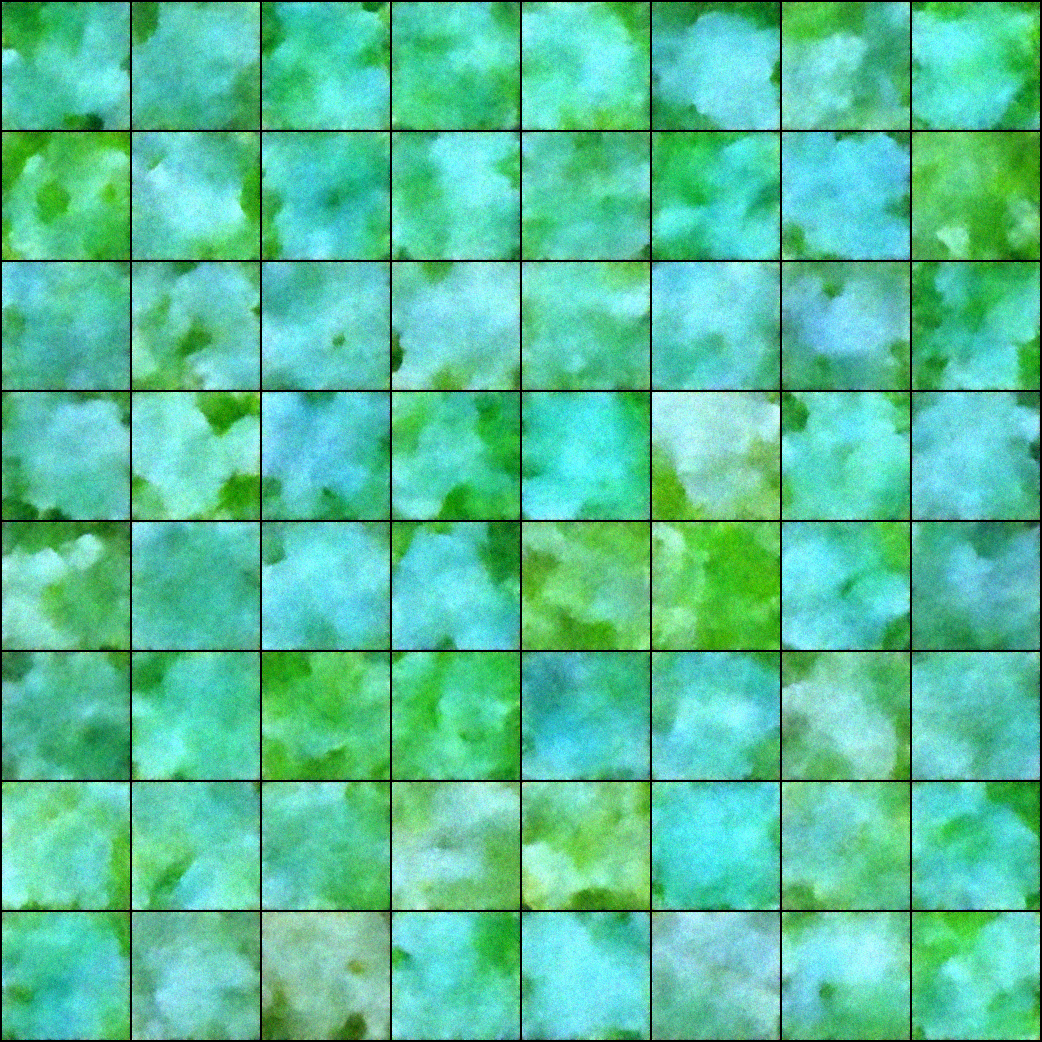

In [129]:
Image.open(sample_path)

## sampling from a pre-trained model 

In [94]:
from sampling import sample_loop, ddpm_sample_step, model_predict
from configs import oxford102_p2

In [104]:
# feel free to choose a different seed
sample_seed = 0
num_sample = 36
wandb_artifact = 'yiyixu/ddpm-flax-flower102/model-38gwgt6w:v0'
sample_bs = 16 # 

In [105]:
cfg = oxford102_p2.get_config()

In [106]:
cfg.ddpm.self_condition=True

In [107]:
shape = (jax.device_count(), 
         sample_bs, 
         cfg.data.image_size, 
         cfg.data.image_size, 
         cfg.data.channels)
shape

(1, 16, 128, 128, 3)

In [108]:
rng = jax.random.PRNGKey(sample_seed)
rng, state_rng = jax.random.split(rng)

state = train.create_train_state(state_rng, cfg)
run = wandb.init()
artifact = run.use_artifact('yiyixu/ddpm-flax-flower102/model-38gwgt6w:v0', type='ddpm_model')
artifact_dir = artifact.download()

state = checkpoints.restore_checkpoint(artifact_dir, state)
state = jax_utils.replicate(state)

ddpm_params = utils.get_ddpm_params(cfg.ddpm)

sample_step = functools.partial(ddpm_sample_step, ddpm_params=ddpm_params, self_condition=cfg.ddpm.self_condition, is_pred_x0=cfg.ddpm.pred_x0)
p_sample_step = jax.pmap(sample_step, axis_name='batch')

print("generating samples")
samples = []
for i in trange(0, num_sample, cfg.data.batch_size):
  rng, sample_rng = jax.random.split(rng)
  samples.append(sample_loop(sample_rng, state, shape, p_sample_step, cfg.ddpm.timesteps))
  samples = jnp.concatenate(samples) # num_devices, batch, H, W, C
          


wandb: Downloading large artifact model-38gwgt6w:v0, 553.34MB. 1 files... Done. 0:0:0.1


generating samples


100%|██████████| 1/1 [01:59<00:00, 119.24s/it]


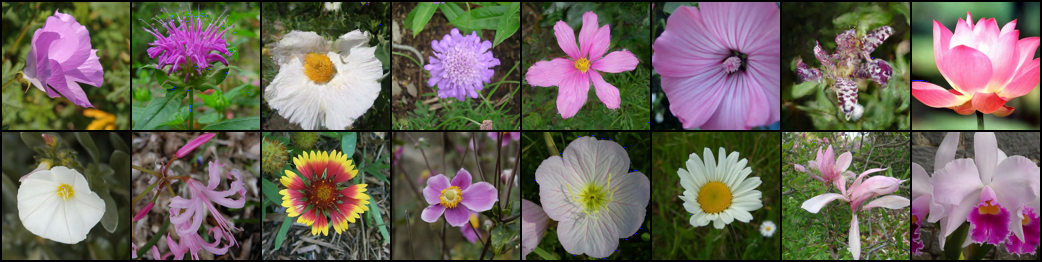

In [111]:
wandb.Image(to_wandb_img(samples)).image